In [1]:
import pandas as pd
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
from functools import partial
import shap 

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import clone

In [2]:
## calculate adjusted R squared
def adjusted_r2(y, preds, p):
    r2 = r2_score(y, preds)
    n = len(y)
    
    adj = 1-(1-r2)*(n-1)/(n-p-1)
    return adj

In [3]:
## display a regression table with coefficients, t-values and p-values
def regression_table(model, X, y):
    model.fit(X,y)
    params = np.append(lm.intercept_,lm.coef_)
    preds = model.predict(X)
    
    adj_r2 = adjusted_r2(y, preds, X.shape[1])
    print('adjusted R2: {:.4f}.'.format(adj_r2))
    
    n = len(X)
    
    beta = [model.intercept_] + model.coef_.tolist()
    X1 = np.column_stack((np.ones(n), X))
    
    sigma_hat = np.sqrt(np.sum(np.square(y - X1@beta)) / (n - X1.shape[1]))
    
    beta_cov = np.linalg.inv(X1.T@X1)
    
    t_vals = beta / (sigma_hat * np.sqrt(np.diagonal(beta_cov)))
    p_vals = t.sf(np.abs(t_vals), n-X1.shape[1])*2 
    
    
    out = pd.DataFrame(zip(X.columns.values, model.coef_.tolist(), np.around(t_vals, 2), np.around(p_vals, 4)), columns=['feature', 'coef', 'T', 'p'])
    return out.set_index('feature')

## EDA

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/candy-power-ranking/candy-data.csv', sep=',')
df.head()

competitorname  chocolate  fruity  caramel  peanutyalmondy  nougat  \
0      100 Grand          1       0        1               0       0   
1   3 Musketeers          1       0        0               0       1   
2       One dime          0       0        0               0       0   
3    One quarter          0       0        0               0       0   
4      Air Heads          0       1        0               0       0   

   crispedricewafer  hard  bar  pluribus  sugarpercent  pricepercent  \
0                 1     0    1         0         0.732         0.860   
1                 0     0    1         0         0.604         0.511   
2                 0     0    0         0         0.011         0.116   
3                 0     0    0         0         0.011         0.511   
4                 0     0    0         0         0.906         0.511   

   winpercent  
0   66.971725  
1   67.602936  
2   32.261086  
3   46.116505  
4   52.341465

In [5]:
df.dtypes

competitorname       object
chocolate             int64
fruity                int64
caramel               int64
peanutyalmondy        int64
nougat                int64
crispedricewafer      int64
hard                  int64
bar                   int64
pluribus              int64
sugarpercent        float64
pricepercent        float64
winpercent          float64
dtype: object

In [6]:
df.isna().sum()

competitorname      0
chocolate           0
fruity              0
caramel             0
peanutyalmondy      0
nougat              0
crispedricewafer    0
hard                0
bar                 0
pluribus            0
sugarpercent        0
pricepercent        0
winpercent          0
dtype: int64

#### Dependent variable
The winrate has a mean of 50% and follows a somewhat normal distribution and is slightly skewed to the left. <br>
The lowest rated candy has a winrate of 22%, while the top entry achieves 84%.

In [7]:
df.winpercent.describe()

count    85.000000
mean     50.316764
std      14.714357
min      22.445341
25%      39.141056
50%      47.829754
75%      59.863998
max      84.180290
Name: winpercent, dtype: float64

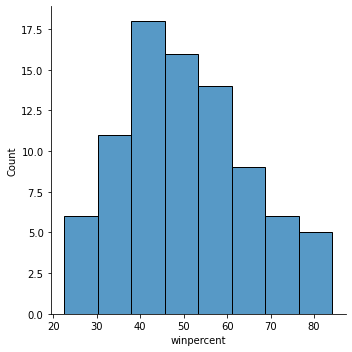

In [8]:
sns.displot(df.winpercent)

#### Binary variables
The binary variables include 6 ingredients and 3 other properties. <br>


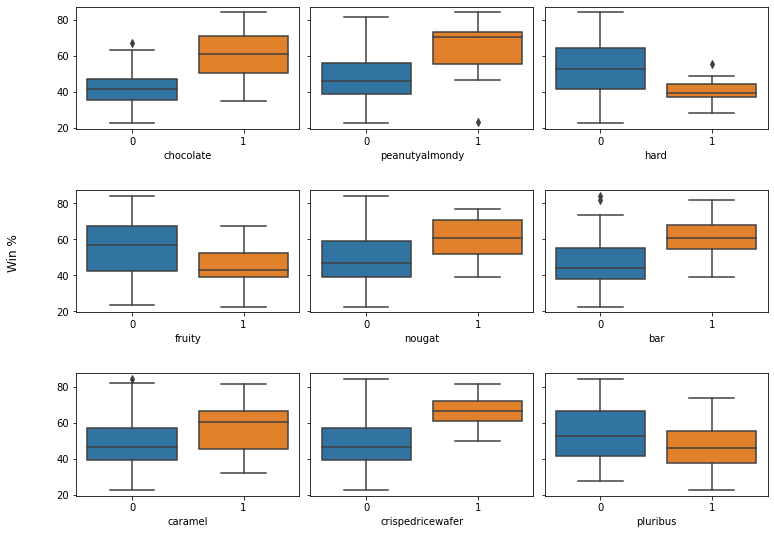

In [9]:
fig, axs = plt.subplots(ncols=3, nrows=3, sharey=True, figsize=(12,9))
for i, c in enumerate(df.select_dtypes('int').columns):
    sns.boxplot(x=c, y='winpercent', data=df, ax=axs[i%3, int(np.floor(i/3))]).set(ylabel=None)
    
fig.supylabel('Win %')
plt.subplots_adjust(hspace=0.5, wspace=0.05, left=0.1)

#### Continuous variables
Sugar content and price are the two continuous variables. <br>
The both display a small positive correlation with the dependent variable. The relationship between price and winrate does not seem linear. The winrates are significantly higher in the 60-80 percentile range and they seem to drop off strongly after the 90th percentile. <br>

Text(0.02, 0.5, 'Win %')

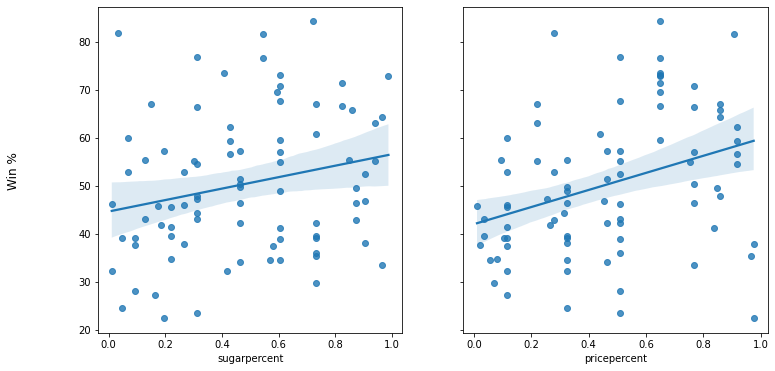

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(12,6))

sns.regplot(x='sugarpercent', y='winpercent', data=df, ax=axs[0]).set(ylabel=None)
sns.regplot(x='pricepercent', y='winpercent', data=df, ax=axs[1]).set(ylabel=None)

fig.supylabel('Win %')

A non-linear function seems to better fit the relationship between price and winrate. A third order polynomial describes the relationship well. Of course this doesnt take any other variables into account so a formal test is needed to confirm the non-linearity.

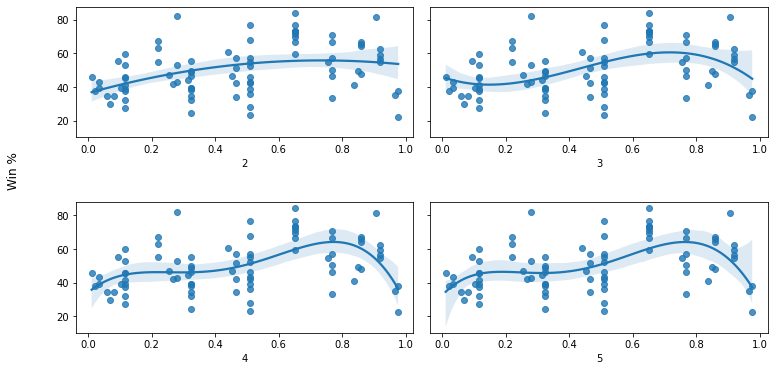

In [11]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharey=True, figsize=(12,6))
for order in range(2,6):
    i = order-2
    sns.regplot(x='pricepercent', y='winpercent', data=df, order=order, ax=axs[int(np.floor(i/2)), i%2]).set(ylabel=None, xlabel=order)
fig.supylabel('Win %')
plt.subplots_adjust(hspace=0.5, wspace=0.05, left=0.1)

##### Regarding the price variable
Since the objective of the underlying study was to determine people's taste in candies, price should have no effect on the winrate. This clearly isnt the case however which leaves a number of possible explanations:
- expensive candy uses higher quality ingredients, which leads to better taste
- people do not rate solely on taste and concsiously or subconcsiously take the brand into account
- chocolate is both more expensive and popular than fruity candy, the price variable is just a reflection of this correlation

Plotting the distributions shows that price has a completely different effect on chocolate and fruity candy. The correlation is positive in the former and negative regarding the latter. The meaning of the price variable remains unclear but it should remain in the model to ensure the highest accuracy.

<AxesSubplot:xlabel='pricepercent', ylabel='winpercent'>

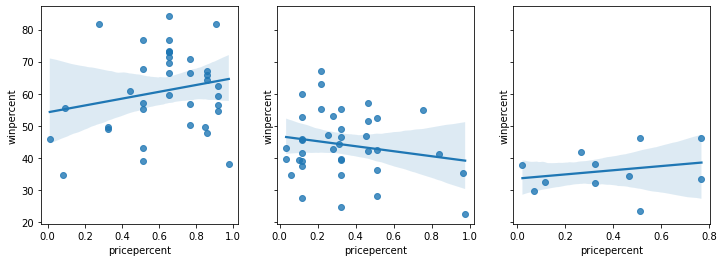

In [12]:
fig, axs = plt.subplots(ncols=3, nrows=1, sharey=True, figsize=(12,4))
sns.regplot(x='pricepercent', y='winpercent', data=df[df.chocolate == 1], ax=axs[0])
sns.regplot(x='pricepercent', y='winpercent', data=df[df.fruity == 1], ax=axs[1])
sns.regplot(x='pricepercent', y='winpercent', data=df[(df.chocolate == 0) & (df.fruity == 0)], ax=axs[2])

#### Correlations
There are a number of mutually exclusive ingredients and properties. Chocolate candy does not contain fruity flavors and is often combined with caramel, nuts, nougat or crisped rice wafers. Fruity candy does not contain chocolate and rarely is accompanied by any of the aforementioned ingredients. Chocolate candies are more expensive, while fruity candy is cheaper. Hard candy is usually fruity and rarely chocolate. Bar and pluribus are mutually exclusive. The former is usually chocolate while the later is more often fruity. <br>
Most variables are somewhat positively correlated with win percentage, only fruity, hard and pluribus show a negative correlation with winrate. 

<AxesSubplot:>

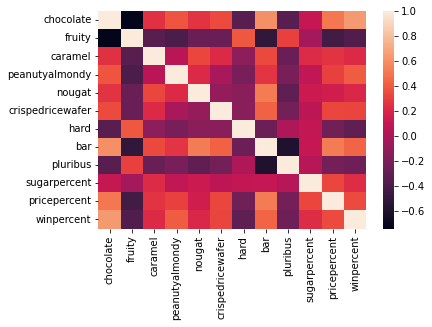

In [13]:
corrMatrix = df.drop(columns=['competitorname']).corr()
sns.heatmap(corrMatrix)

## k-means clustering
One way to look at this problem, is to group candies into clusters and identify the cluster which is the most popular. The recommendation would then be to create a candy that would be similar to the ones in the winning cluster.

In [14]:
X = df.drop(columns=['competitorname', 'winpercent'])
y = df.winpercent

#### Principal component analysis
With sparse, binary data it is usually a good idea to perform PCA before clustering to convert the variables to 
continuous vectors. The explained variance drops of sharply after two components.

Text(0, 0.5, 'Explained variance')

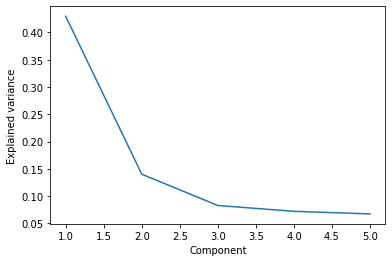

In [15]:
pca = PCA(n_components=5)
pca.fit(X)
sns.lineplot(y=pca.explained_variance_ratio_, x=range(1,6))
plt.xlabel('Component')
plt.ylabel('Explained variance')

In [16]:
pca = PCA(n_components=2)
X = pca.fit_transform(X)

Based on the two components, one can roughly see four distinct groups.

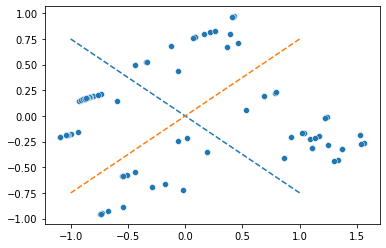

In [17]:
sns.scatterplot(x=X[:,0], y=X[:,1])
plt.plot([-1, 1], [0.75, -0.75], '--')
plt.plot([-1, 1], [-0.75, 0.75], '--')

#### Clustering
Using k-means cluster with k=4, the four groups shown above are almost exactly replicated.

In [18]:
kmeans = KMeans(n_clusters=4, random_state=13).fit(X)

<AxesSubplot:>

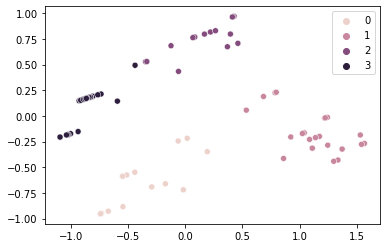

In [19]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue=kmeans.labels_)

In [20]:
df['cluster'] = kmeans.labels_

#### Cluster attributes
Looking at the feature distributions, one is able to characterize each cluster.

| Cluster | Main Flavor | Quantity | Price |
| --- | --- | --- | --- | 
| 0 | Fruity | Single | Low | 
| 1 | Chocolate | Single | High | 
| 2 | Chocolate | Pluribus | Medium | 
| 3 | Fruity | Pluribus | Low | 

The main divide seems to be between chocolate and fruity on the one side and pluribus and bars on the other.

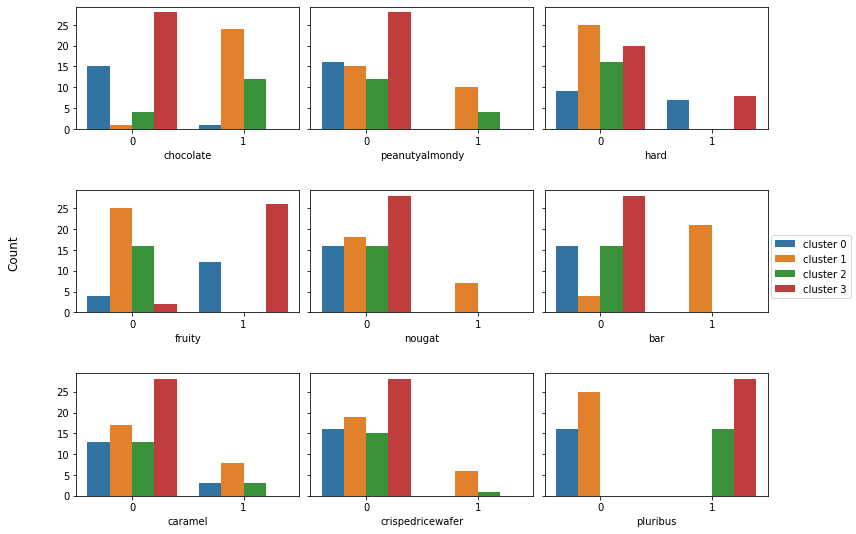

In [21]:
fig, axs = plt.subplots(ncols=3, nrows=3, sharey=True, figsize=(12,9))
for i, c in enumerate(df.iloc[:,1:10].columns):
    sns.countplot(x=c, hue='cluster', data=df, ax=axs[i%3, int(np.floor(i/3))]).set(ylabel=None)
    axs[i%3, int(np.floor(i/3))].legend().set_visible(False)
    
handles, labels = axs[2,2].get_legend_handles_labels()
fig.legend(handles, ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3'], loc='center right')

fig.supylabel('Count')
plt.subplots_adjust(hspace=0.5, wspace=0.05, left=0.1)

Text(0.02, 0.5, 'Win %')

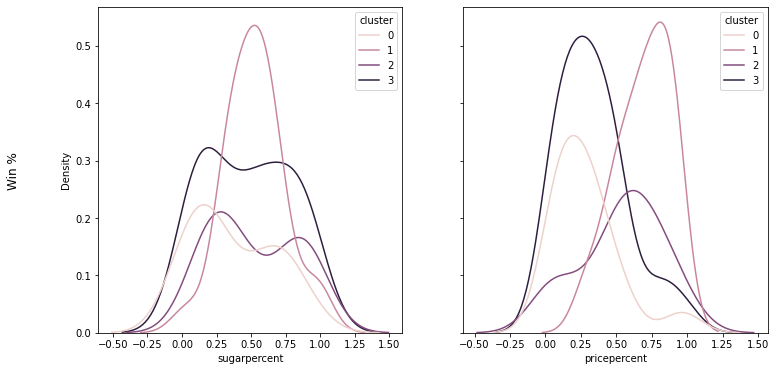

In [22]:
fig, axs = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(12,6))
sns.kdeplot(x=df.sugarpercent, hue=df['cluster'], ax=axs[0])
sns.kdeplot(x=df.pricepercent, hue=df['cluster'], ax=axs[1])
fig.supylabel('Win %')

#### Cluster winrates
Chocolate bars are the clear winner, they score significantly higher than the other three clusters. Fruity candy performs below average in most cases. Chocolate pluribus has the largest range and can perform both very well or extremely bad. <br>
Using the cluster as features in a linear regression shows that their distributions are significantly different from each other. With cluster 0 as the baseline, cluster 1 achieves a 22 point higher winrate. This confirms that cluster 1, single-item chocolate candies are by far the most popular group.

<AxesSubplot:xlabel='cluster', ylabel='winpercent'>

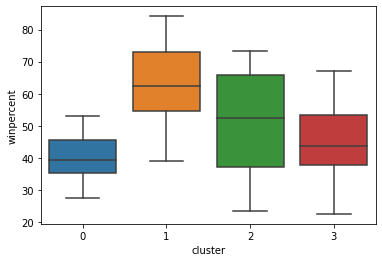

In [23]:
sns.boxplot(x='cluster', y='winpercent', data=df)

In [24]:
lm = LinearRegression()
X = pd.get_dummies(df['cluster'], drop_first=True)
y = df['winpercent']
regression_table(lm, X, y)

adjusted R2: 0.3246.


coef      T      p
feature                         
1        22.298558  13.39  0.000
2        10.232079   5.76  0.000
3         4.136475   2.39  0.019

### Leave-one-out cross-validation
To assess out-of-sample error rates it is necessary to test the model against unknown data. The dataset is extremely small, so holdout sets and regular k-fold cross validation are not feasible. Leave-one-out cross-validation is a possible alternative for very small datasets, where k=n.

In [25]:
def loocv(model, X, y):
    preds = []
    for i in range(len(X)):
        model.fit(X.drop(i).values, y.drop(i).values)
        p = model.predict(X.iloc[i].values.reshape(1, -1))
        preds.append(p)
    
    r2 = r2_score(y, preds)
    adj_r2 = adjusted_r2(y, preds, X.shape[1])

    return r2, adj_r2

In [26]:
## GridSearchCV cant handle loo-cv with R² since the score is calculated after each fold
## I make a custom grid-search function with multithreading
def get_score(p, model, X, y):
    model_copy = clone(model)
    model_copy.set_params(**p)
    _, adj_r2 = loocv(model_copy, X, y)
    return adj_r2

def loogridsearch(model, X, y, params, n_jobs=6):
    scores = []
    grid = ParameterGrid(params)
    
    with Pool(n_jobs) as p:
        f = partial(get_score, model=model, X=X, y=y)
        scores = p.map(f, list(grid))
    
    ix = scores.index(max(scores))

    return scores, scores[ix], list(grid)[ix]

## Linear regression
Next I will perform a linear regression on the data. <br>
A linear regression is probably not able to produce accurate predictions based on this dataset. I.i.d assumptions are probably not fulfilled as there is multicollinearity between the features.

In [27]:
X = df.drop(columns=['competitorname', 'winpercent', 'cluster'])
y = df.winpercent

In [28]:
lm = LinearRegression()

One should be careful in judging the coefficients of this linear regression, as it does not take into account the various interactions between variables. <br>
One thing that is very obvious is the strong positive correlation between chocolate and winrate, not surprising considering the findings of the cluster analysis.

In [29]:
regression_table(lm, X, y)

adjusted R2: 0.4709.


coef     T       p
feature                                  
chocolate         19.748067  7.99  0.0000
fruity             9.422322  5.07  0.0000
caramel            2.224481  2.50  0.0145
peanutyalmondy    10.070688  0.61  0.5449
nougat             0.804331  2.79  0.0068
crispedricewafer   8.918970  0.14  0.8885
hard              -6.165327  1.69  0.0947
bar                0.441540 -1.78  0.0785
pluribus          -0.854500  0.09  0.9307
sugarpercent       9.086763 -0.28  0.7794
pricepercent      -5.928361  1.95  0.0550

The linear regression model performs significantly worse on unseen data. This is most likely a result of overfitting. One way to decrease overfitting and improve validation performance is L2 regularization. <br>

In [30]:
_, score = loocv(lm, X, y)
print('LOO-CV adjusted R2: {:.4f}'.format(score))

LOO-CV adjusted R2: 0.2538


#### Regularization
As expected, the model has much better out of sample performance after applying L2 regularization.

In [31]:
ridge = Ridge()

In [32]:
_, score = loocv(ridge, X, y)
print('LOO-CV adjusted R2: {:.4f}'.format(score))

LOO-CV adjusted R2: 0.2869


#### Polynomial features
Using polynomial transformations of the price variable does not improve the model.

In [33]:
poly = PolynomialFeatures(4, include_bias=False)
X[['pricepercent', 'pricepercent2', 'pricepercent3', 'pricepercent4']] = poly.fit_transform(pd.DataFrame(X['pricepercent']))

In [34]:
regression_table(lm, X, y)

adjusted R2: 0.4914.


coef     T       p
feature                                    
chocolate           20.255058  3.53  0.0008
fruity               8.741377  5.28  0.0000
caramel              0.846350  2.30  0.0242
peanutyalmondy       7.038195  0.23  0.8172
nougat               0.819727  1.81  0.0749
crispedricewafer     7.940601  0.14  0.8901
hard                -4.972865  1.52  0.1327
bar                 -0.354409 -1.44  0.1542
pluribus            -0.566666 -0.07  0.9452
sugarpercent         6.023970 -0.19  0.8523
pricepercent       156.590832  1.26  0.2134
pricepercent2     -674.096616  1.69  0.0964
pricepercent3     1071.911128 -1.79  0.0786
pricepercent4     -563.840760  1.88  0.0647

In [35]:
_, score = loocv(lm, X, y)
print('LOO-CV adjusted R2: {:.4f}'.format(score))

LOO-CV adjusted R2: 0.2161


In [36]:
_, score = loocv(ridge, X, y)
print('LOO-CV adjusted R2: {:.4f}'.format(score))

LOO-CV adjusted R2: 0.2645


#### Hyperparameter tuning
By optimizing the L2 alpha, I am able to increase R² by another percentage point.

In [37]:
X = df.drop(columns=['competitorname', 'winpercent', 'cluster'])
y = df.winpercent

In [38]:
_, score = loocv(ridge, X, y)
print('LOO-CV adjusted R2: {:.4f}'.format(score))

LOO-CV adjusted R2: 0.2869


In [39]:
ridge = Ridge()

In [40]:
params = {'alpha':[0.1, 1.0, 2.0, 2.2, 2.5, 2.7, 3.0]}
scores, best_score, best_params = loogridsearch(ridge, X, y, params)

print('Best score: {:.4f}'.format(best_score))
print('Best Params: {}'.format(best_params))

Best score: 0.2957
Best Params: {'alpha': 2.5}


The result on the full set is worse compared to the most basic linear regression discussed above. This is to be expected, since the model is now regularized and better suited for out of sample predictions.

In [41]:
ridge = Ridge(**best_params)
ridge.fit(X, y)
preds = ridge.predict(X)
score = adjusted_r2(y, preds, X.shape[1])
print('adjusted R2 on full set: {:.4f}'.format(score))

adjusted R2 on full set: 0.4451


## Random Forest
The natural choice for predicting on tabular data is a random forest model. Compared to an OLS regression, decision trees have some very important advantages. It can naturally handle interactions between different features and non-linear relationships. Also it is non parametric and doesnt rely on any statistical assumptions. <br>
After some hyperparameter tuning, the random forest gets up to a validation score of 0.35. It is thus much better suited for predictions on unseen data.

In [42]:
rf = RandomForestRegressor()

In [43]:
_, score = loocv(rf, X, y)
print('LOO-CV adjusted R2: {:.4f}'.format(score))

LOO-CV adjusted R2: 0.2785


In [46]:
params = {'max_depth': [10, 20, 30],
          'n_estimators': [30, 50, 100, 200],
          'min_samples_split': [2,4],
          'min_samples_leaf': [1,2,4],
          'max_features': ['sqrt', 'log2']
         }

scores, best_score, best_params = loogridsearch(rf, X, y, params)

print('Best score: {:.4f}'.format(best_score))
print('Best Params: {}'.format(best_params))

Best score: 0.3530
Best Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


Regarding the full set, the random forest model is able to achieve a very high R² of 0.67, completely declassing all linear models.

In [49]:
rf = RandomForestRegressor(**best_params)
rf.fit(X,y)
preds = rf.predict(X)
score = adjusted_r2(y, preds, X.shape[1])
print('adjusted R2 on full set: {:.4f}'.format(score))

adjusted R2 on full set: 0.6687


### Model interpretation
The graph of feature importances shows again that chocolate is by far the most important factor in predicting a candies popularity. Price, sugar content and nuts are also of relatively high importance. <br>

In [50]:
explainer = shap.TreeExplainer(rf)

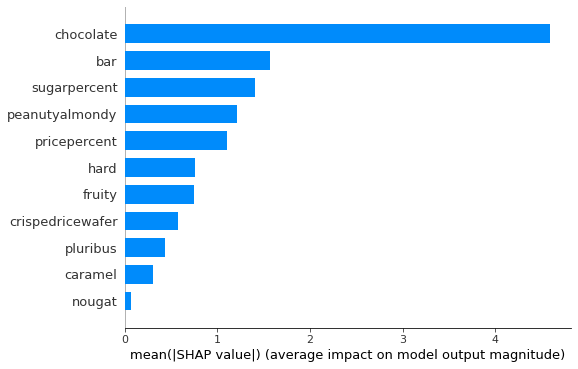

In [51]:
shap_values = shap.TreeExplainer(rf).shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

The disadvantage of a random forest model is that it is much harder to interpret compared to a linear model. I will take a quick look at three predictions to show what factors influence the model output. <br>
First up is the gold medalist in this competition: Reeses Peanut Butter cup. <br>
This candy gets a very high prediction because it contains chocolate in combination with nuts. The medium high price and medium high sugar content seem to be right inside the sweet spot.

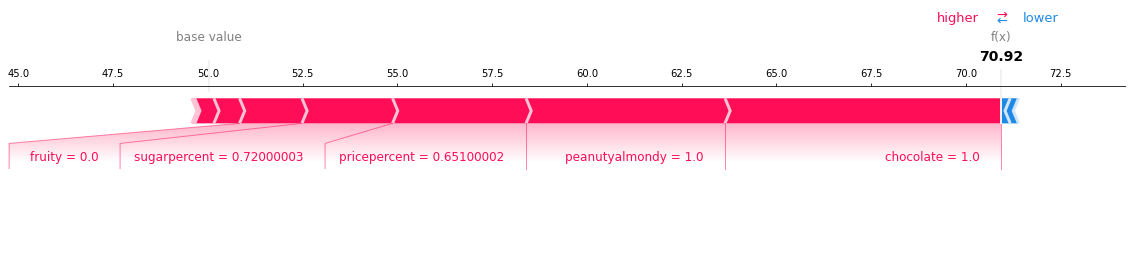

In [52]:
view = df.loc[[df.winpercent.idxmax()]].drop(columns=['competitorname'])
shap_values = explainer.shap_values(view)
shap.force_plot(explainer.expected_value[0], shap_values[0], view, matplotlib=True)

Next is the last place: Nik L Nip. <br>
This is a fruity candy, which is, as established earlier, not a good start. But even bigger problems of this candy are that the price is very high and the sugar content is very low.

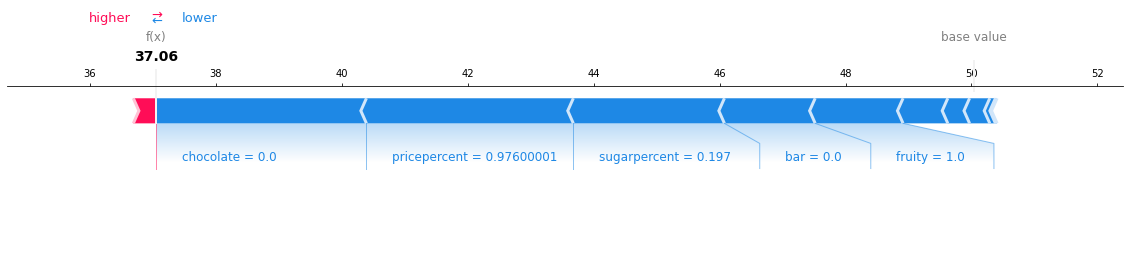

In [53]:
view = df.loc[[df.winpercent.idxmin()]].drop(columns=['competitorname'])
shap_values = explainer.shap_values(view)
shap.force_plot(explainer.expected_value[0], shap_values[0], view, matplotlib=True)

And lastly, lets take a look at a German classic: Haribo Gold Bears. <br>
It is a fruity type of candy, which is a disadvantage in this competition, but compared to other fruity candies it is able to get a somewhat decent score by having the right price and sugar content.

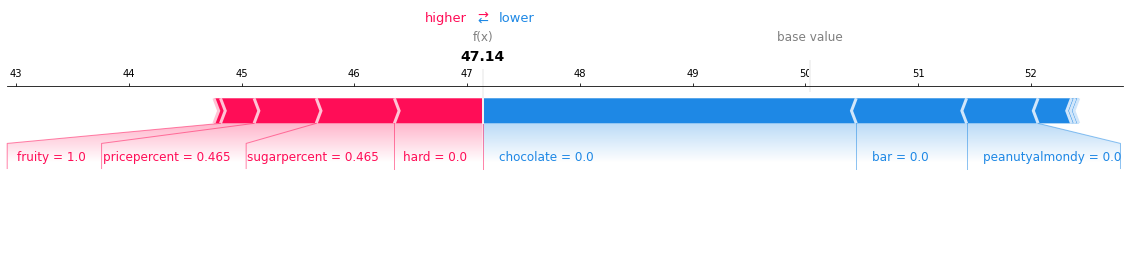

In [54]:
view = df.loc[[18]].drop(columns=['competitorname'])
shap_values = explainer.shap_values(view)
shap.force_plot(explainer.expected_value[0], shap_values[0], view, matplotlib=True)

Save model.

In [55]:
from joblib import dump, load
dump(rf, 'random_forest.joblib') 

['random_forest.joblib']

## Additional analysis

#### Lower price segment
When only looking at candies with prices in the bottom 50%, the lead of single-item chocolate candies becomes even larger, scoring 22 points higher than pluribus chocolate and 17-24 points higher than fruity candy. <br>
When it comes to cheaper candies, there isnt a significant difference between singular and pluribus fruity candy anymore.

<AxesSubplot:xlabel='cluster', ylabel='winpercent'>

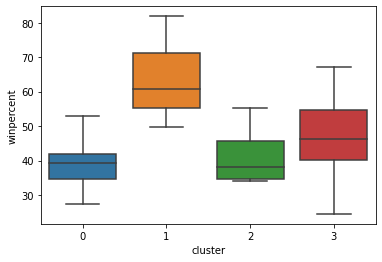

In [56]:
sns.boxplot(x='cluster', y='winpercent', data=df[df.pricepercent < 0.5])

In [57]:
lm = LinearRegression()
X = pd.get_dummies(df.loc[df.pricepercent < 0.5, 'cluster'], drop_first=True)
y = df.loc[df.pricepercent < 0.5, 'winpercent']
regression_table(lm, X, y)

adjusted R2: 0.2402.


coef      T       p
feature                          
1        24.586295  14.39  0.0000
2         2.080299   3.88  0.0004
3         7.024221   0.40  0.6919

#### Pure chocolate vs other ingredients
Pure chocolate performs significantly worse compared to chocolate candy with other additional ingredients. 

In [58]:
df['purechocolate'] = df[['peanutyalmondy', 'caramel', 'nougat', 'crispedricewafer']].sum(axis=1) == 0

<AxesSubplot:xlabel='purechocolate', ylabel='winpercent'>

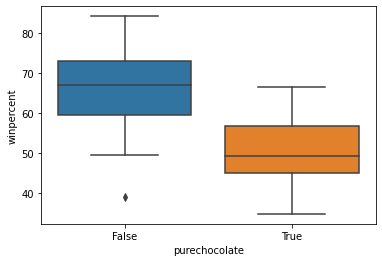

In [59]:
sns.boxplot(x='purechocolate', y='winpercent', data=df.loc[df.chocolate == 1])

In [60]:
lm = LinearRegression()
X = df.loc[df.chocolate == 1,['purechocolate']]
y = df.loc[df.chocolate == 1, 'winpercent']
regression_table(lm, X, y)

adjusted R2: 0.3247.


coef      T    p
feature                            
purechocolate -15.82141  31.37  0.0

#### Additional ingredients
When looking at chocolate candies which contain at least one other ingredient, the differences in scores regarding the different ingredients are small or insignificant. <br>
Only peanut and almonds show a statistically significant positive effect, but the sample size is too small at this point to draw conclusions.

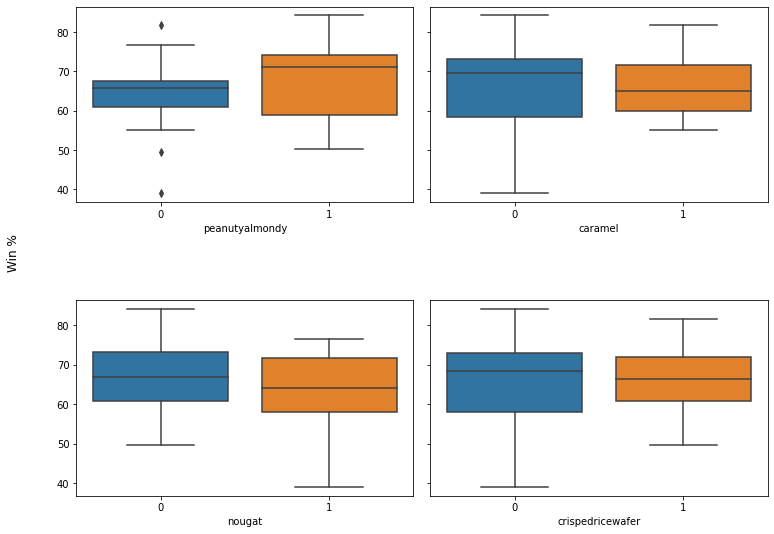

In [61]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharey=True, figsize=(12,9))

sns.boxplot(x='peanutyalmondy', y='winpercent', data=df.loc[(df.chocolate == 1) & (df.purechocolate == 0)], ax=axs[0,0]).set(ylabel=None)
sns.boxplot(x='caramel', y='winpercent', data=df.loc[(df.chocolate == 1) & (df.purechocolate == 0)], ax=axs[0,1]).set(ylabel=None)
sns.boxplot(x='nougat', y='winpercent', data=df.loc[(df.chocolate == 1) & (df.purechocolate == 0)], ax=axs[1,0]).set(ylabel=None)
sns.boxplot(x='crispedricewafer', y='winpercent', data=df.loc[(df.chocolate == 1) & (df.purechocolate == 0)], ax=axs[1,1]).set(ylabel=None)

fig.supylabel('Win %')
plt.subplots_adjust(hspace=0.5, wspace=0.05, left=0.1)

In [62]:
X = df.loc[(df.chocolate == 1) & (df.purechocolate == 0),['peanutyalmondy', 'caramel', 'nougat', 'crispedricewafer']]
y = df.loc[(df.chocolate == 1) & (df.purechocolate == 0), 'winpercent']

In [63]:
regression_table(lm, X, y)

adjusted R2: -0.0957.


coef      T       p
feature                                  
peanutyalmondy    5.280781  11.01  0.0000
caramel           2.775956   0.94  0.3591
nougat           -4.450364   0.54  0.5959
crispedricewafer  1.042266  -0.69  0.4981